
s0,n9 t:0.000010 0.156080 0.664910 0.155340 0.249080 0.155250 0.662170 0.155750 0.253580 
s1,n9 t:0.024590 0.156080 0.664920 0.155330 0.249080 0.155250 0.662170 0.155750 0.253590 
s2,n9 t:0.054590 0.156080 0.664920 0.155330 0.249080 0.155250 0.662170 0.155750 0.253590 
s3,n8 t:0.400420 0.156090 0.664910 0.155330 0.249090 0.155250 0.817920 0.253580 
s4,n10 t:0.427670 0.156090 0.664910 0.155330 0.249090 0.155250 0.662170 0.155750 0.000010 0.253570 
s5,n9 t:0.456840 0.156080 0.664920 0.155330 0.249080 0.155250 0.662170 0.155750 0.253590 
s6,n11 t:0.802670 0.156080 0.664920 0.155330 0.249090 0.155250 0.662170 0.000010 0.155740 0.253580 0.000010 
s7,n9 t:0.832170 0.156080 0.664920 0.155330 0.249090 0.155250 0.662170 0.155750 0.253580 
s8,n9 t:0.851750 0.156090 0.664910 0.155340 0.249080 0.155250 0.662170 0.155750 0.253580 
s9,n10 t:1.197590 0.156080 0.664920 0.000010 0.155320 0.249080 0.155250 0.662170 0.155750 0.253590 
s10,n9 t:1.215090 0.156080 0.664920 0.155330 0.249080 0.155250 0.6621

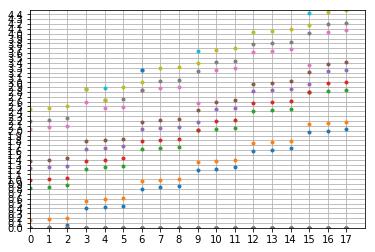

In [3]:
import matplotlib.pyplot as plt
import numpy as np

VT_WH = 8  #中间速度所在轴
VT_SS = 8  #中间速度所在传感器
V0 = 12    #初始速度 3
V1 = 12    #中间速度 500
V2 = 12    #最终速度 5
time_vt = 0 #经过中间速度时的时刻值
def v_cal(time):
    #t_v0_v1 = 3;    #初始速度到中间速度持续时间
    #t_v1_v2 = 3;    #中间速度到最终速度持续时间
    if(0 == vt_flag):
        return V0 + time*a
    #elif(time < t_v1_v2):
        #return v0 + time*(v2 - v1)/t_v1_v2
    else:
        return V1 + (time-time_vt)*a
    
    
SSA_NUM = 6
SS_NUM = SSA_NUM*3
WH_NUM = 9
WHR_NUM = WH_NUM * 2
T_1US = 0.000001
T_10US =  0.00001
sx = []    #传感器x坐标
wx = []    #车轴x坐标
wx_init = []
ds = []    #传感器间距
dw = []    #轴距
lwn = [0 for i in range(SS_NUM)]         #每个传感器的丢轴个数
rwn = [0 for i in range(SS_NUM)]         #每个传感器的多轴个数
swn = [WH_NUM for i in range(SS_NUM)]    #每个传感器经过的实际轮轴数，加上多轴，减去丢轴
ws = [0 for i in range(SS_NUM)]          #每个轴经过的传感器数

dt =  T_10US
t = [[0]*SS_NUM for i in range(WHR_NUM)]         #绝对时刻表 t[i][j] i:轴数 j:传感器号
dwst = [[0]*SS_NUM for i in range(WHR_NUM)]      #相对时刻表
lost_ax = [[0]*SS_NUM for i in range(WH_NUM)]    #丢轴标志表
red_ax = [[0]*SS_NUM for i in range(WH_NUM)]     #多轴时间表
ws_order = [[0]*SS_NUM for i in range(WH_NUM)]   #次序表


#丢轴设置
lost_ax[6][3] = 1;
#lost_ax[0][12] = 1;
#lost_ax[10][9] = 1;
#lost_ax[12][9] = 1;
#lost_ax[10][11] = 1;
#lost_ax[3][11] = 1;
#lost_ax[6][9] = 1; 
#多轴设置
#red_ax[7][6] = T_10US*5000;
#red_ax[14][6] = T_10US*5000;
#red_ax[16][6] = T_10US*5000;
red_ax[7][4] = T_10US;
#red_ax[13][1] = T_10US;
red_ax[6][6] = T_10US;
red_ax[8][6] = T_10US;
red_ax[2][9] = T_10US;
red_ax[2][15] = T_10US;

#sx = 0.0
#wx[0] = -1.0
ds = [0.295,0.360,4.150,0.327,0.350,4.150,0.354,0.235,4.150,0.210,0.350,4.150,0.206,0.344,4.150,0.223,0.345]
dw = [1.873,7.979,1.864,2.989,1.863,7.946,1.869,3.043,1.858,7.955,1.843,3.785,2.031,1.992,4.689,2.043,1.977]
#print(ds[0])
sx.append(0)
wx.append(0)
wx_init.append(0)
for i in range(0,SS_NUM-1):
    sx.append(sx[i]+ds[i])
for i in range(0,WH_NUM-1):
    wx.append(wx[i]-dw[i])
    wx_init.append(wx[i]-dw[i])
for i in range(0,SS_NUM-1):
    swn.append(WH_NUM)
for i in range(0,WH_NUM):
    ws.append(0)
time = 0
v = 23
#t.append(0)
ws_order.append(0)
order = 0
vt_flag = 0
a = (V1**2 - V0**2)/2/(sx[VT_SS] - wx_init[VT_WH])
while(wx[WH_NUM-1] < sx[SS_NUM-1] + 30 * dt):
    time += dt
    v = v_cal(time)
    #print(v)
    for i in range(0,WH_NUM):
        wx[i] += dt * v
    for i in range(0,WH_NUM):
        for j in range(ws[i],SS_NUM):
            if wx[i] > sx[j]:
                ws[i] += 1
                t[i][j] = time
                ws_order[i][j] = order
                order += 1
                if(VT_WH == i and VT_SS == j):
                    a = (V2**2 - V1**2)/2/((sx[SS_NUM-1] - sx[VT_SS]) + (wx_init[VT_WH] - wx_init[WH_NUM-1]))
                    time_vt = time
                    vt_flag = 1
                
#for i in range(0,WH_NUM):
#    print('')
#    for j in range(0,SS_NUM):
#        print('%8f ' % t[i][j],end = '')
        
#for i in range(0,WH_NUM):
#    print('')
#    for j in range(0,SS_NUM):
#        print('%4d ' % ws_order[i][j],end = '')

        
#//处理丢轴多轴
for j in range(0,SS_NUM):
    for i in range(0,WH_NUM):
        if lost_ax[i][j]:
            t[i][j] = 0
            swn[j] -= 1
            lwn[j] += 1
    for i in range(WH_NUM-1,0,-1):
        if red_ax[i][j] > T_1US:
            swn[j] += 1
            rwn[j] += 1
            for k in range(WH_NUM-1+rwn[j],i,-1):
                t[k][j] = t[k-1][j]
            t[i+1][j] = t[i][j] + red_ax[i][j]
print('')
#print(t)
#%matplotlib qt
#fig1 = plt.figure('fig1')
#plt.grid(True)
#plt.xlim((0,SS_NUM))
#plt.ylim((0,max(t[max(swn)])))
#plt.xticks(np.arange(0,SS_NUM,1))
#plt.yticks(np.arange(0,4,0.1))
#plt.plot(list(map(list,(zip(*t)))),'.')
#plt.plot(list(map(list,(zip(*t))))[0:max(swn)],'.')
#fig1.show()

#//整理丢轴
for j in range(0,SS_NUM):
    for i in range(0,WH_NUM-1+rwn[j]):
        if(t[i][j] < T_1US):
            for k in range(i,WH_NUM-1+rwn[j]):
                t[k][j] = t[k+1][j]

#//计算周期除了第0行后面的数据
for j in range(0,SS_NUM):
    for i in range(0,swn[j]):
        dwst[i+1][j] = t[i+1][j] - t[i][j]

#//计算第0行数据
for j in range(0,SS_NUM):
    dwst[0][j] = t[0][j]
#dwst[0][0] = 0

#//计算第0行数据
#for j in range(0,SS_NUM-1):
#    dwst[0][j+1] = t[0][j+1] -  t[0][j]
#dwst[0][0] = 0



for j in range(0,SS_NUM):
    print('s%d,n%d t:' % (j,swn[j]),end = '')
    for i in range(0,swn[j]):
        print('%.6f ' % dwst[i][j],end = '')
    print('')

frame = [[0]*SS_NUM for i in range(WHR_NUM*3+8)]    #帧

for j in range(0,SS_NUM):
    frame[0][j] = 0x5a
    frame[1][j] = 0xff
    frame[2][j] = (swn[j]*3+8 & 0xff00) >> 8
    frame[3][j] = swn[j]*3+8 & 0x00ff
    frame[4][j] = j
    frame[5][j] = swn[j]
    
for j in range(0,SS_NUM):
    for i in range(0,swn[j]):
        tmp = round(dwst[i][j]*100000)
        frame[6+i*3][j] = (tmp & 0xff0000) >> 16
        frame[6+i*3+1][j] = (tmp & 0x00ff00) >> 8
        frame[6+i*3+2][j] = (tmp & 0x0000ff)


crc_tmp = [0 for i in range(SS_NUM)]
for j in range(0,SS_NUM):
    crc_tmp[j] = 0xffff
    for i in range(0,swn[j]*3+6):
        crc_tmp[j] ^= frame[i][j]
        for k in range(0,8):
            if(crc_tmp[j] & 0x01):
                crc_tmp[j] = (crc_tmp[j] >> 1) ^ 0xa001
            else:
                crc_tmp[j] = crc_tmp[j] >> 1


for j in range(0,SS_NUM):
    frame[swn[j]*3+6][j] = (crc_tmp[j] & 0xff00) >> 8
    frame[swn[j]*3+7][j] = crc_tmp[j] & 0xff
        

for j in range(0,SS_NUM):
    print('s%2d,n%2d t:' % (j,swn[j]),end = '')
    for i in range(0,swn[j]*3+8):
        print('%02x ' % frame[i][j],end = '')
    print('')

#%matplotlib qt
#fig2 = plt.figure('absolute time table')
plt.grid(True)
plt.xlim((0,SS_NUM))
plt.ylim(0,max(t[WH_NUM-1]))
plt.xticks(np.arange(0,SS_NUM,1))
plt.yticks(np.arange(0,max(t[WH_NUM-1]),0.1))
plt.plot(list(map(list,(zip(*t)))),'.')
plt.show()
#print(dwst)
#for j in range(0,SS_NUM):
#    for i in range(0,swn[j]):
#        print('t[%d][%d]=%10f ' % (i,j,t[i][j]))
        
#print(rwn)
#for j in range(SS_NUM-1,-1,-1):
#    print(j)
#for i in range(0,WH_NUM):
    #print(i,wx[i])

#%matplotlib qt
#plt.plot(t[0:max(swn)],'.')
#plt.grid(True)
#plt.show()



In [11]:
print(crc_tmp)

[44815, 4064, 51755, 44443, 7051, 55284, 23271, 12275, 34684, 1032, 2957, 42947, 46721, 16065, 23651, 45469, 62748, 13723]
